We provide the following data to support experimentation with signal representation and classification techniques. Please acknowledge us in any communications of your work involving our data.

We have worked primarily with EEG data recorded by Zak Keirn at Purdue University for his work on his Masters of Science thesis in the Electrical Engineering Department at Purdue. We make that data available here as a 23 MB, binary Matlab mat-file. After downloading this file, load it into matlab using load eegdata. You should then have these two variables defined:

>> whos

Name     |   Size    |    Bytes | Class
---------|-----------|----------|-----------
data     |   1x325   | 22917020 | cell array
readme   |   1x1379  |     2758 | char array

Grand total is 5699264 elements using 22919778 bytes
The variable readme is a string containing the following explanation:

data is a cell array of cell arrays. Each individual cell array is made up of a subject string, task string, trial string, and data array. Each data array is 7 rows by 2500 columns. The 7 rows correspond to channels c3, c4, p3, p4, o1, o2, and EOG. Across columns are samples taken at 250 Hz for 10 seconds, for 2500 samples. For example, the first cell array looks like 'subject 1' 'baseline' 'trial 1' [7x2500 single]. Recordings were made with reference to electrically linked mastoids A1 and A2. EOG was recorded between the forehead above the left browline and another on the left cheekbone. Recording was performed with a bank of Grass 7P511 amplifiers whose bandpass analog filters were set at 0.1 to 100 Hz. data 1 and 2 were employees of a university and were left-handed age 48 and right-handed age 39, respectively. data 3 through 7 were right-handed college students between the age of 20 and 30 years old. All were mail data with the exception of Subject 5. data performed five trials of each task in one day. They returned to do a second five trials on another day. data 2 and 7 completed only one 5-trial session. Subject 5 completed three sessions. For more information see Alternative Modes of Communication Between Man and Machine, Zachary A. Keirn, Masters Thesis in Electrical Engineering, Purdue University, December, 1988.

Here is a file named makesubset.m that will extract five 7x2500 matrices for Subject 1, Trial 1 of each of the five tasks and plots them. This can be run only after loading the eegdata.mat file.

If you don't have access to Matlab, or want more data, here is a 12.8 MB file named alleegdata.ascii.gz that contains data for all data. Values are stored with a precision of three decimal places to save space.

In [2]:
%pip install pandas numpy

     |████████████████████████████████| 9.5 MB 3.6 MB/s eta 0:00:01     |███▉                            | 1.1 MB 3.6 MB/s eta 0:00:03
     |████████████████████████████████| 505 kB 25.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Importing libraries

In [2]:
import numpy as np
import pandas as pd
from scipy import signal

import shutil

from os import listdir, makedirs

import re
import py7zr
import gzip

# import the neccesary libraries to read mat files
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
import glob
import re
import pickle

import time
import datetime
import math
import random
import warnings

from os import listdir, makedirs

import importlib

from core.utils2 import fbcca, generate_ref_signal
warnings.filterwarnings('ignore')


## Download the data

### Benchmar dataset

In [2]:
# Downlaod the archives of the following URL dir:
# https://bci.med.tsinghua.edu.cn/upload/yijun/SXX.mat.7z
# Where XX is from 1 to 35

makedirs('data', exist_ok=True)
makedirs('data/benchmark', exist_ok=True)
makedirs('data/benchmark/7z', exist_ok=True)
makedirs('data/benchmark/extracted', exist_ok=True)


# DOwnload the archives
s = 1 
e = 35

# benchmark dataset
# for i in range(s, e + 1):
#     !wget https://bci.med.tsinghua.edu.cn/upload/yijun/S{i}.mat.7z -P data/7z/

# Extract the archives in the following directory
archive_dir = 'data/benchmark/7z/'
# The extracted files will be in the following directory
extracted_dir = 'data/benchmark/extracted/'

### Extract the data

In [5]:

# Create the extracted directory
makedirs(extracted_dir, exist_ok=True)

# List the archives
archives = listdir(archive_dir)

# Extract the archives
for archive in archives:
    print(archive.split('.')[0])
    with py7zr.SevenZipFile(archive_dir + archive, mode='r') as z:
        z.extractall(path=extracted_dir)

# List the extracted files
extracted_files = listdir(extracted_dir)

S6
S1
S3
S31
S21
S13
S7
S19
S5
S16
S12
S22
S24
S17
S4
S34
S29
S14
S27
S26
S33
S10
S23
S35
S2
S11
S8
S32
S25
S15
S30
S20
S18
S28
S9


In [8]:
# move the data from data/benchmark/extracted/ to data/raw/
makedirs('data/raw', exist_ok=True)

for file in extracted_files:
    shutil.move(extracted_dir + file, 'data/raw/' + file)

# Now, download the Frq.mat file
# https://bci.med.tsinghua.edu.cn/upload/yijun/Freq_Phase.mat
# and move it to data/raw/
!wget https://bci.med.tsinghua.edu.cn/upload/yijun/Freq_Phase.mat -P data/raw/

--2024-09-08 03:22:22--  https://bci.med.tsinghua.edu.cn/upload/yijun/Freq_Phase.mat
Resolving bci.med.tsinghua.edu.cn (bci.med.tsinghua.edu.cn)... 101.6.15.70, 2402:f000:1:402:101:6:15:70
Connecting to bci.med.tsinghua.edu.cn (bci.med.tsinghua.edu.cn)|101.6.15.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366 [application/octet-stream]
Saving to: ‘data/raw/Freq_Phase.mat’

Freq_Phase.mat      100%[===================>]     366  --.-KB/s    in 0s      

2024-09-08 03:22:24 (431 MB/s) - ‘data/raw/Freq_Phase.mat’ saved [366/366]



np.pad(x, ((0, 0), (0, (2**int(np.ceil(np.log2(x.shape[-1]))) - x.shape[-1]))), 'constant')

# Colorado dataset

Download and extract the data

In [17]:
# make folders if not exist
makedirs('data/colorado/7z/', exist_ok=True)
makedirs('data/colorado/extracted/', exist_ok=True)

!wget https://www.cs.colostate.edu/eeg/data/alleegdata.ascii.gz -P data/colorado/7z/

# Extract the Colorado dataset
with gzip.open('data/colorado/7z/alleegdata.ascii.gz', 'rb') as f_in:
    !touch data/colorado/extracted/alleegdata.ascii # this only works in linux
    with open('data/colorado/raw/alleegdata.ascii', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

--2024-09-07 10:04:43--  https://www.cs.colostate.edu/eeg/data/alleegdata.ascii.gz
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.48
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12804390 (12M) [application/x-gzip]
Saving to: ‘data/colorado/7z/alleegdata.ascii.gz’

alleegdata.ascii.gz 100%[===================>]  12.21M  4.41MB/s    in 2.8s    

2024-09-07 10:04:46 (4.41 MB/s) - ‘data/colorado/7z/alleegdata.ascii.gz’ saved [12804390/12804390]



## Create the partitions of the data

We only need the baselines, not the tasks

> Colorado dataset

In [ ]:

# The file (alleegdata.ascii) has the following contents:
# Line 1: "subject 1, baseline, trial 1"
# Line 2: 2500 samples of channel c3
# Line 3: 2500 samples of channel c4
# ...
# Line 8: 2500 samples of channel EOG
# Line 9: "subject 1, baseline, trial 2"
# ...
# Line 56: "subject 1, baseline, trial 5"
# Line 57: "subject 1, task 1, trial 1"
# ...
# And so on

# separate each trial 
with open('data/colorado/raw/alleegdata.ascii') as f:
    lines = f.read().split("\n\n")
    # remove the first line
    lines.pop(0)

print(lines[0])

# we only want resting EEG, so we use the baseline
data = [line for line in lines if "baseline" in line]

subjects_data = []
subjects = []

past = ""

# clear df
df = None

for trial in data:

    rows = trial.split("\n")
    print(f"Rows: {rows}")
    head = rows[0].strip().split(",")
    rows.pop(0)
    
    for i in range(0, len(rows)):
        rows[i] = np.array(rows[i].strip().split(" "), dtype=float)
        
    rows.append(np.repeat(head[2], len(rows[0])))

    if len(rows) == 8:
        df_ = pd.DataFrame(rows).transpose()
        if past == head[0] and df is not None:
            # concat the dataframes
            df = pd.concat([df, df_], axis=0)
        else:
            # Rename the columns
            subjects.append(head[0])
            if df is not None:
                df.columns = ['c3', 'c4', 'p3', 'p4', 'o1', 'o2', 'eog', 'trial']
                # Add oz, which is the average of o1 and o2 channels
                df['oz'] = (df['o1'] + df['o2']) / 2
                subjects_data.append(df)
            # append the dataframe
            df = df_

        # keep track of the subject
        past = head[0]

# add the last subject
subjects.append(past[0])

In [32]:
makedirs('data/colorado/processed/', exist_ok=True)

In [1]:
subjects_data[4]

NameError: name 'subjects_data' is not defined

In [26]:
# Save the dataframes
for subject in subjects_data:
    # save each task separately
    trials = subject['trial'].unique()
    columns = ['o1', 'o2', 'oz']
    for trial, i in zip(trials, subjects):
        subject[subject['trial'] == trial][columns].to_csv('data/colorado/processed/' + i.replace("subject", 's').replace(" ", "") + '_' + trial.replace(" ", "") + '.csv', index=False)


## Final processing

In [9]:
# Processed files at: data/processed/*.csv
# Read all the files, and create 4 second (1000 samples) windows for each one, use 0.5s of overlap

path = "data/processed/"
files = listdir(path)

fs = 250

w_len = 4 * fs

overlap = int(0.5 * fs)

for file in files:
    df = pd.read_csv(path + file)
    # 4 seconds of data, 0.5s of overlap
    for i in range(0, len(df), w_len - overlap):
        if i + w_len < len(df):
            df_ = df[i:i+w_len]
            out = df_.to_numpy().swapaxes(0, 1)
            print(out.shape)
            # save the file (npy)
            np.save('data/final/0/' + file.replace(".csv", "") + '_' + str(i) + '.npy', out)
            

(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)
(3, 1000)


## Train test split

In [10]:
def is_perfect_score_subject(file: str, subjects: list):
    # re.match(f"^{subject}_.\.npy$", file)
    for subject in subjects:
        if re.match(f"^S{subject}_.\.npy$", file) is not None:
            return True
        
    return False

In [ ]:
files = listdir("data/staged/")


src_path = "data/staged/"
dst_path_train = "data/train/"
dst_path_test  = "data/val/"

perfect_score_subjects = [1, 3, 6, 15, 24, 27, 28, 31, 32]

for file in files:
    print(file)
    files_ = listdir(src_path + file)

    # create folders on train and test paths if they don't exist
    if not file in listdir(dst_path_train):
        makedirs(dst_path_train + file)
    if not file in listdir(dst_path_test):
        makedirs(dst_path_test + file)

    N = len(files_)

    for i in range(N):
        if is_perfect_score_subject(files_[i], perfect_score_subjects):
            print(f"perfect score subject: {files_[i]}")
            # copy the file to the train folder
            shutil.copy(src_path + file + "/" + files_[i], dst_path_train + file + "/" + files_[i])
        else:
            # copy the file to the test folder
            shutil.copy(src_path + file + "/" + files_[i], dst_path_test + file + "/" + files_[i])


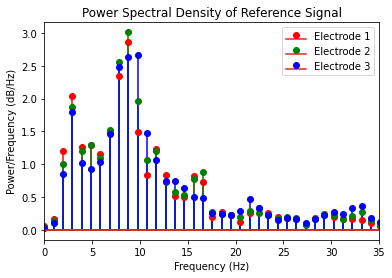

In [6]:
prr = np.load("expr/results/ref_00_b.npy")
prr = prr[3, :, :]
colors = ['r', 'g', 'b']

for i in range(3):
    freqs, psd = signal.welch(prr[i], fs=250)
    plt.stem(freqs, psd, label='Electrode ' + str(i+1), use_line_collection=True, linefmt=colors[i], markerfmt=colors[i] + 'o')


plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density of Reference Signal')
plt.legend()
plt.xlim(0, 35)
plt.show()

(3, 1024)


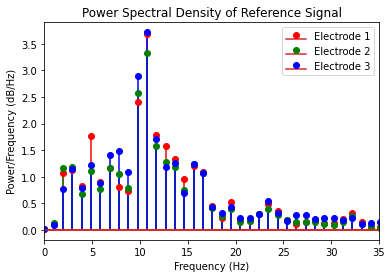

In [7]:
prr = np.load("data/train/0/S1_1.npy")

print(prr.shape)
# prr shape = 3, 1024 (3 electrodes, 1024 samples)

# Plot the power spectral density of each electrode
# put the points and lines in the same plot but with different colors

colors = ['r', 'g', 'b']

for i in range(3):
    freqs, psd = signal.welch(prr[i], fs=250)
    plt.stem(freqs, psd, label='Electrode ' + str(i+1), use_line_collection=True, linefmt=colors[i], markerfmt=colors[i] + 'o')


plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density of Reference Signal')
plt.legend()
plt.xlim(0, 35)
plt.show()